In [80]:
# In this project, I will try to detect communities within a network. This network is a network of Star Wars characters that interacted with each other at Star Wars: Episode I - The Phantom Menace. The dataset includes nodes as characters and edges as characters who spoke to each other within a given scene(Gabasova, E. (2016). Star Wars social network. DOI: https://doi.org/10.5281/zenodo.1411479). 



In [81]:
# Firstly, it is important to import necessary libraries for the project.

import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import metrics
from scipy.spatial.distance import cdist


from src.helper import draw_spring, load_graph_from_json
np.random.seed(123)

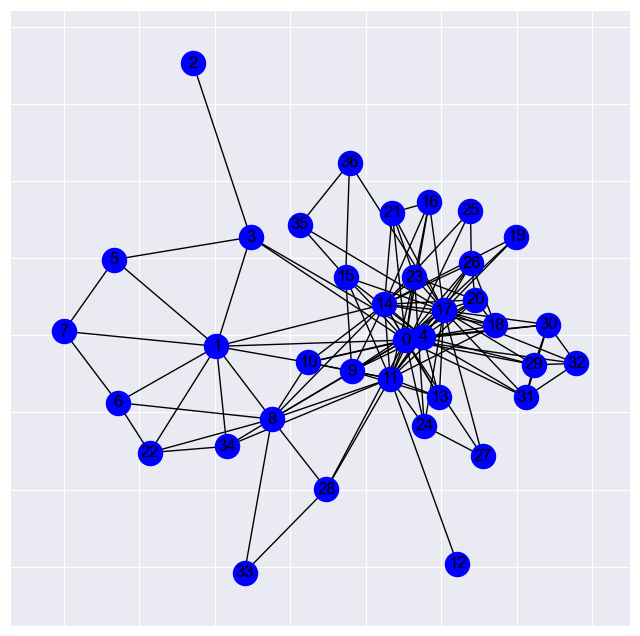

In [82]:
# We load the graph and print it out to have a glance at it

episode_one = load_graph_from_json("data/starwars-episode-1-interactions.json")
draw_spring(episode_one)

In order to detect communities within a given network, one can apply a popular unsupervised machine learning algorithm: KMeans clustering. We use an unsupervised machine learning algorithm as our data is not labelled and we do not exactly know which communities our nodes belong to.

But in order to apply this machine learning algorithm to our data, we need to transform our data in a format which our algorithm could process. This is a very important step as how we transform our data will directly affect the efficiency of the algorithm we use. 
 Social Networks or Networks in general have their basis on graph theory. According to the graph theory, if we want to represent out network with a more abstract but computable format, we should use matrices. 

We will not use adjacency matrix as it can not represent interactions between nodes that are not directly linked to each other but share a common node as a neighbor. This would result in an information loss which in turn makes adjacency matrix not feasible for our project.

Laplacian matrix, while being good at offering information about localized structures including immediate neighbors, lacks in the ability to capture global structures and community-level information within a network

It is better to use spectral clustering instead. Compared to the aforementioned methods, spectral clustering leverages the eigenvalue decomposition of a laplacian matrix. This decomposition makes detecting global structures and inter-community relationships possible which greatly enhances our capabilities to detect communities.

In [83]:
# In order to start our project, we need the laplacian matrix of our graph.

laplacian_episode_one = nx.laplacian_matrix(episode_one)


The subsequent stage involves identifying the eigenvector corresponding to the n smallest non-zero eigenvalues, with the value of n determined by the desired number of clusters. For instance, if the objective is to achieve two clusters, the focus would be on the smallest eigenvector. Conversely, when aiming for three clusters, the attention shifts to the two smallest eigenvectors, and so forth. We can obtain a list of eigenvalues using Numpy and print them for reference.

In [84]:
# this get us the values and the vectors
vals, vecs = np.linalg.eig(laplacian_episode_one.todense())
# here we extract the values
vals

array([2.60438378e+01, 2.30592822e+01, 1.91019396e+01, 1.80465333e+01,
       1.39942669e+01, 1.21321528e+01, 1.06678656e+01, 9.75712054e+00,
       9.47203882e+00, 1.53786145e-15, 7.99564351e+00, 7.06595441e-01,
       9.61928056e-01, 1.03505675e+00, 1.42372864e+00, 1.70529838e+00,
       7.51096520e+00, 2.27879132e+00, 2.45366811e+00, 2.53517598e+00,
       2.88885334e+00, 3.21385860e+00, 3.32613920e+00, 7.08165700e+00,
       4.05947876e+00, 4.39403138e+00, 4.43343685e+00, 4.97424504e+00,
       5.18571337e+00, 5.45799023e+00, 5.61528053e+00, 6.28790617e+00,
       6.19952048e+00, 4.00000000e+00, 6.00000000e+00, 7.00000000e+00,
       7.00000000e+00])

We will now sort the values to spot the smallest values and then round it in order to avoid complications.

In [85]:
np.sort(vals)

array([1.53786145e-15, 7.06595441e-01, 9.61928056e-01, 1.03505675e+00,
       1.42372864e+00, 1.70529838e+00, 2.27879132e+00, 2.45366811e+00,
       2.53517598e+00, 2.88885334e+00, 3.21385860e+00, 3.32613920e+00,
       4.00000000e+00, 4.05947876e+00, 4.39403138e+00, 4.43343685e+00,
       4.97424504e+00, 5.18571337e+00, 5.45799023e+00, 5.61528053e+00,
       6.00000000e+00, 6.19952048e+00, 6.28790617e+00, 7.00000000e+00,
       7.00000000e+00, 7.08165700e+00, 7.51096520e+00, 7.99564351e+00,
       9.47203882e+00, 9.75712054e+00, 1.06678656e+01, 1.21321528e+01,
       1.39942669e+01, 1.80465333e+01, 1.91019396e+01, 2.30592822e+01,
       2.60438378e+01])

In [86]:
np.sort(np.round(vals,5))

array([ 0.     ,  0.7066 ,  0.96193,  1.03506,  1.42373,  1.7053 ,
        2.27879,  2.45367,  2.53518,  2.88885,  3.21386,  3.32614,
        4.     ,  4.05948,  4.39403,  4.43344,  4.97425,  5.18571,
        5.45799,  5.61528,  6.     ,  6.19952,  6.28791,  7.     ,
        7.     ,  7.08166,  7.51097,  7.99564,  9.47204,  9.75712,
       10.66787, 12.13215, 13.99427, 18.04653, 19.10194, 23.05928,
       26.04384])

To avoid errors caused by finding values manually, let's find the smallest value that is not zero by using a numpy function.

In [87]:
# because python indexes start at 0, indexing at 1 will give us the second smallest value.
smallest_non_zero = np.sort(vals,)[1]
np.where(vals==smallest_non_zero)

(array([11], dtype=int64),)

In [88]:
#Let's confirm it

vals[11]

0.7065954412503314

We now aim to retrieve the eigenvector corresponding to the smallest non-zero eigenvalue, which is located at position 11. To achieve this, we simply need to access the 11th column (starting from zero) of the eigenvector variable.

In [89]:
X = vecs[:,11]
X = np.asarray(X)
X

array([ 0.03600164, -0.07373556, -0.84989194, -0.24936217,  0.02886085,
       -0.21184767, -0.0876791 , -0.16275468,  0.00265731,  0.0439401 ,
        0.02133386,  0.05306318,  0.1808533 ,  0.05041281,  0.04347506,
        0.06709378,  0.06098427,  0.06151457,  0.05830842,  0.06147684,
        0.05494414,  0.06098427, -0.05492982,  0.05985462,  0.06557685,
        0.06810386,  0.05965147,  0.07111395,  0.03720924,  0.05746039,
        0.05746039,  0.05746039,  0.06286325,  0.03082296, -0.02214878,
        0.09943397,  0.09943397])

We then reshape our matrix to two-dimensional array for our unsupervised machine learning algorithm.

In [90]:
print(X.shape)
# the -1 here says "give me as many rows as necessary", the 1 says "and just one column"
X = X.reshape(-1,1)
print(X.shape)

(37,)
(37, 1)


Before applying our machine learning algorithm, we could see that there are two distinct groups of data within our matrix by first sorting our matrix and then visually plotting it. Namely, positive and negative values. One might think that because of this we should select two clusters for out algorithm. But we need to consider      domain knowledge in our projects as well. In this context, simply seperating the data into two clusters wouldn't suffice as we know that there are more than one      faction in the Star Wars Episode I: Phantom Menace. We will translate this information to communities within the network we have.

We have 6 different factions or communities at Episode I. These are Galactic Republic, The Jedi Order, The Sith ,Trade Federation, Naboo and Gungans. Because of this, we will select 6 clusters.

In [91]:
np.sort(X, axis=0)

array([[-0.84989194],
       [-0.24936217],
       [-0.21184767],
       [-0.16275468],
       [-0.0876791 ],
       [-0.07373556],
       [-0.05492982],
       [-0.02214878],
       [ 0.00265731],
       [ 0.02133386],
       [ 0.02886085],
       [ 0.03082296],
       [ 0.03600164],
       [ 0.03720924],
       [ 0.04347506],
       [ 0.0439401 ],
       [ 0.05041281],
       [ 0.05306318],
       [ 0.05494414],
       [ 0.05746039],
       [ 0.05746039],
       [ 0.05746039],
       [ 0.05830842],
       [ 0.05965147],
       [ 0.05985462],
       [ 0.06098427],
       [ 0.06098427],
       [ 0.06147684],
       [ 0.06151457],
       [ 0.06286325],
       [ 0.06557685],
       [ 0.06709378],
       [ 0.06810386],
       [ 0.07111395],
       [ 0.09943397],
       [ 0.09943397],
       [ 0.1808533 ]])

<Axes: >

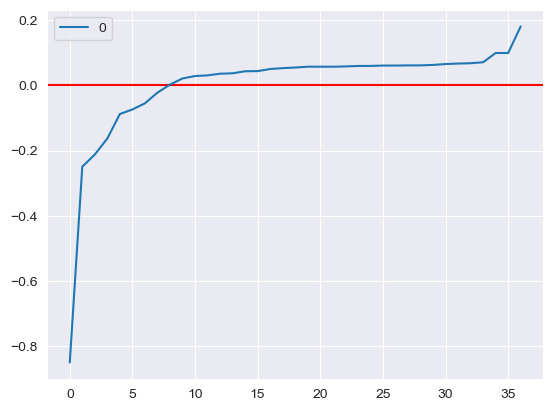

In [92]:
plt.axhline(0, color="red")
sns.lineplot(np.sort(X, axis=0))

In [93]:
from sklearn.cluster import KMeans
km = KMeans(6)

# Kmeans will return an array, but networkx (in the next cell) will want a list. 
# Therefore we need to convert it to a list, and get the indexes (the positions) in the list where our results lie

results = list(km.fit_predict(X))


nodes_cluster_1 = [x[0] for x in enumerate(results) if x[1]==0]
print("nodes for cluster 1", nodes_cluster_1,"\n")
nodes_cluster_2 = [x[0] for x in enumerate(results) if x[1]==1]
print("nodes for cluster 2", nodes_cluster_2,"\n")
nodes_cluster_3 = [x[0] for x in enumerate(results) if x[1]==2]
print("nodes for cluster 3", nodes_cluster_3,"\n")
nodes_cluster_4 = [x[0] for x in enumerate(results) if x[1]==3]
print("nodes for cluster 4", nodes_cluster_4,"\n")
nodes_cluster_5 = [x[0] for x in enumerate(results) if x[1]==4]
print("nodes for cluster 5", nodes_cluster_5,"\n")
nodes_cluster_6 = [x[0] for x in enumerate(results) if x[1]==5]
print("nodes for cluster 6", nodes_cluster_6,"\n")


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


nodes for cluster 1 [11, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 35, 36] 

nodes for cluster 2 [2] 

nodes for cluster 3 [3, 5, 7] 

nodes for cluster 4 [1, 6, 22, 34] 

nodes for cluster 5 [12] 

nodes for cluster 6 [0, 4, 8, 9, 10, 14, 28, 33] 


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12136\2245486593.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", len(np.unique(labels)))


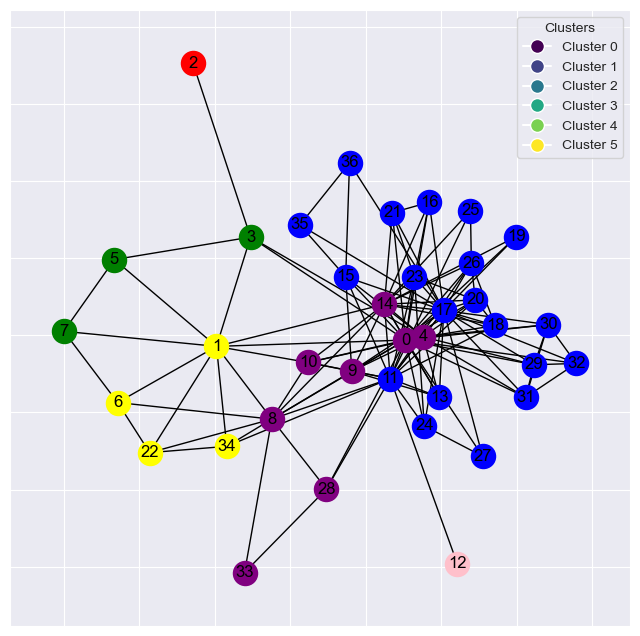

In [94]:
labels = km.fit_predict(X)  # 'features' represent the features of your nodes

# Create a colormap for the clusters
cmap = plt.cm.get_cmap("viridis", len(np.unique(labels)))

# Create a dictionary to map nodes to their corresponding cluster color
color_map = {node: cmap(label) for node, label in zip(episode_one.nodes, labels)}

plt.figure(figsize=(8,8))
pos = nx.spring_layout(episode_one, seed =123)
nx.draw_networkx_nodes(episode_one, pos=pos, nodelist=list(nodes_cluster_1), node_color="blue")
nx.draw_networkx_nodes(episode_one, pos=pos, nodelist=list(nodes_cluster_2), node_color="red")
nx.draw_networkx_nodes(episode_one, pos=pos, nodelist=list(nodes_cluster_3), node_color="green")
nx.draw_networkx_nodes(episode_one, pos=pos, nodelist=list(nodes_cluster_4), node_color="yellow")
nx.draw_networkx_nodes(episode_one, pos=pos, nodelist=list(nodes_cluster_5), node_color="pink")
nx.draw_networkx_nodes(episode_one, pos=pos, nodelist=list(nodes_cluster_6), node_color="purple")

# Create a legend for the clusters
legend_labels = [f"Cluster {i}" for i in range(len(np.unique(labels)))]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(np.unique(labels)))]
plt.legend(legend_handles, legend_labels, title="Clusters", loc="upper right")

nx.draw_networkx_labels(episode_one, pos=pos)
nx.draw_networkx_edges(episode_one, pos=pos)

In [95]:
for node, data in episode_one.nodes(data=True):
    print(f"Node {node}: {data.get('name', 'No Name Attribute')}")

Node 0: QUI-GON
Node 1: NUTE GUNRAY
Node 2: PK-4
Node 3: TC-14
Node 4: OBI-WAN
Node 5: DOFINE
Node 6: RUNE
Node 7: TEY HOW
Node 8: EMPEROR
Node 9: CAPTAIN PANAKA
Node 10: SIO BIBBLE
Node 11: JAR JAR
Node 12: TARPALS
Node 13: BOSS NASS
Node 14: PADME
Node 15: RIC OLIE
Node 16: WATTO
Node 17: ANAKIN
Node 18: SEBULBA
Node 19: JIRA
Node 20: SHMI
Node 21: C-3PO
Node 22: DARTH MAUL
Node 23: KITSTER
Node 24: WALD
Node 25: FODE/BEED
Node 26: JABBA
Node 27: GREEDO
Node 28: VALORUM
Node 29: MACE WINDU
Node 30: KI-ADI-MUNDI
Node 31: YODA
Node 32: RABE
Node 33: BAIL ORGANA
Node 34: GENERAL CEEL
Node 35: BRAVO TWO
Node 36: BRAVO THREE


In [96]:
node_cluster_map = {node: label for node, label in zip(episode_one.nodes, labels)}

print("\nNode-Cluster Assignments:")
for cluster in np.unique(labels):
    nodes_in_cluster = [node for node, label in node_cluster_map.items() if label == cluster]
    print(f"Cluster {cluster}: {nodes_in_cluster}")


Node-Cluster Assignments:
Cluster 0: [0, 4, 8, 9, 10, 14, 28, 33]
Cluster 1: [2]
Cluster 2: [3, 5, 7]
Cluster 3: [1, 6, 22, 34]
Cluster 4: [12]
Cluster 5: [11, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 35, 36]


Results do not match with our initial hypothesis: We aimed to cluster nodes based on their qualitative attribute of allegiance to certain factions. But quantity and attribute of their interactions(edges, direct connection and indirect connections) are not limited to their respective factions. Characters interactions with other characters within a given scene could be limited to a member of another faction. Such is the case for Roos Tarpals, a Gungan warrior belonging to Gungan faction. But his only interaction is with Jar-Jar, a Gungan outcasts belonging to a different faction because of his status. Because of this, Roos Tarpals has his own cluster but he is not in a cluster with other members of the Gungan faction.